In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv', delimiter=',')

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])


In [8]:
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [9]:
# Mapping 'Yes'/'No' to 1/0
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Mapping 'Male'/'Female' to 1/0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [10]:
df.drop(columns=['customerID'], inplace=True)

In [11]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

In [12]:
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

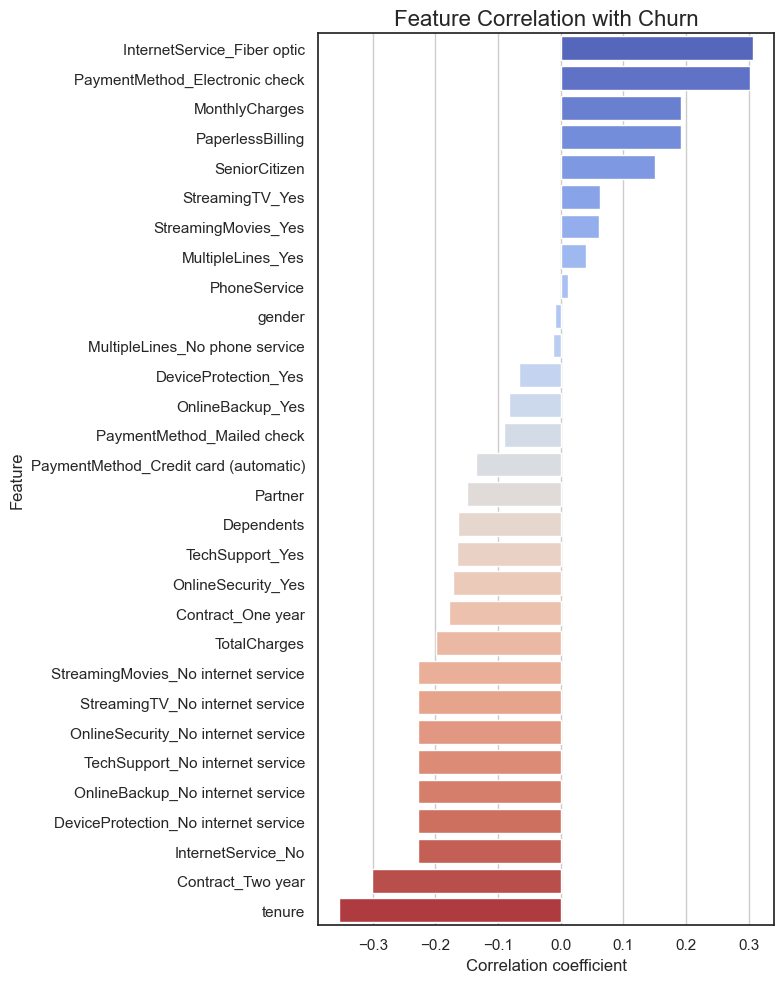

In [16]:
# Compute correlations with target
churn_corr = df.corr(numeric_only=True)['Churn'].drop('Churn').sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(x=churn_corr.values, y=churn_corr.index, hue=churn_corr.index,
            palette="coolwarm", legend=False)
plt.title("Feature Correlation with Churn", fontsize=16)
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [22]:
churn_corr

InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
PhoneService                             0.011691
gender                                  -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner                                 -0.149982
Dependents                              -0.163128
TechSupport_Yes                         -0.164716
OnlineSecurity_Yes                      -0.171270
Contract_One year                       -0.178225


### 🔍 Correlation with Churn – Key Insights

The correlation analysis reveals that customers with **fiber optic internet**, **electronic check payment**, and **higher monthly charges** are more likely to churn. In contrast, customers with **longer tenure**, **two-year contracts**, and **value-added services** like *Tech Support* and *Online Security* show lower churn rates. These patterns highlight which features are most predictive and will inform our feature selection and model design.


## Model Assessment

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

models = {}

## Logistic Regression

In [47]:
y = df['Churn']
X = df.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(X_train)
# x_test_scaled = scaler.transform(X_test)
x_train_scaled = X_train
x_test_scaled = X_test

In [49]:
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [50]:
y_pred = logreg.predict(x_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7867803837953091
Confusion Matrix:
 [[915 118]
 [182 192]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



### ROC Curve and AUC

ROC AUC Score: 0.8319235288940887


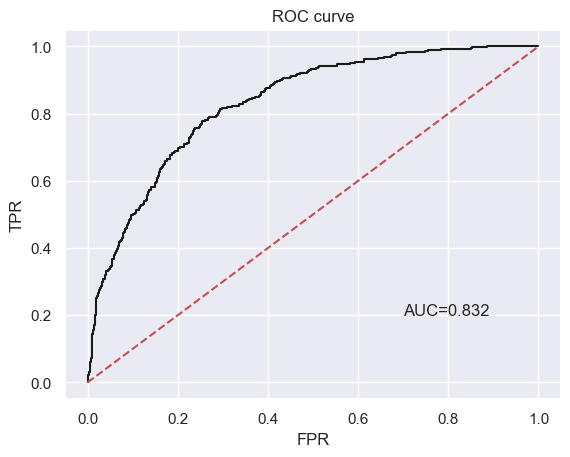

In [51]:
ypp = logreg.predict_proba(x_test_scaled)
fpr, tpr, th = roc_curve(y_test, ypp[:, 1])
auc = roc_auc_score(y_test, ypp[:, 1])
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC='+'{:.3f}'.format(auc))

print("ROC AUC Score:", roc_auc_score(y_test, y_probs))